# Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг

Бербер Кирилл, 317 группа, максимальный из возможных баллов - 11.2! 

## О задании ## 
В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

#  Часть 1. Bias-Variance Decomposition

In [200]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [201]:
from sklearn.datasets import load_boston


In [202]:
boston = load_boston()


In [203]:
X = boston["data"]
y = boston["target"]

In [32]:
X.shape, y.shape

((506, 13), (506,))

In [40]:
X

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [310]:
#y

## Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$

- $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
- $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
- $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
- $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.


С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

**Приближенное вычисление интегралов**

На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:

$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что $\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [9]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.58698972881974

**Оценивание $\mathbb{E}_{x, y}$**

Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:

$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

**Оценивание $\mathbb{E}_X$ с помощью бутстрапа**

Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

**Итоговый алгоритм оценки смещения и разброса алгоритма $a$**

1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
2. На каждой выборке $X_j$ обучить алгоритм $a_j$.
3. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания 
алгоритма $a_j$ на объектах $T_j$.


Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:

- Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
- Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
- Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.
В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!


**Задание 1. (1.5 баллa)**

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [2]:
import numpy as np

In [293]:
b = np.array([1, 2, 3])
d = c - b[:, np.newaxis]
d**2

array([[1., 1., 1., 1.],
       [4., 4., 4., 4.],
       [9., 9., 9., 9.]])

In [282]:
a = np.empty((3,))
a[:] = np.nan
b = np.array([1, 2, 3])
a+b

array([nan, nan, nan])

In [198]:
import random
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    matr_predict = np.empty((X.shape[0], num_runs))
    matr_predict[:] = np.nan
    set_of_selected = set()
    for i in range(num_runs):
        lst = np.arange(X.shape[0])
        sampling = np.random.choice(lst, X.shape[0], replace = True)
        regressor.fit(X[sampling], y[sampling])
        derelict = list(set(lst) - set(sampling))
        #if i == 0:
        #    print(len(derelict))
        set_of_selected.update(derelict)
        matr_predict[derelict, i] = regressor.predict(X[derelict])
        #end
    #print(len(np.nanmean(matr_predict, axis=1)))
    #print(len(y))

    bias = np.nanmean((np.nanmean(matr_predict, axis=1)-y)**2)
    
    variance_1 = (matr_predict - np.nanmean(matr_predict, axis=1)[:, np.newaxis])**2
    variance_2 =  np.nanmean(variance_1, axis = 1)
    variance = np.nanmean(variance_2)
    
    error = np.nanmean(np.nanmean((matr_predict - y[:, np.newaxis])**2, axis=1))
    return bias, variance, error

In [353]:
lll = np.arange(10)
sampl = random.choices(lll, k = 5)
sampl

[8, 1, 7, 8, 3]

**Задание 2. (0.5 баллa)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [354]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
randf = RandomForestRegressor(max_depth=2, random_state=0)
destr = DecisionTreeRegressor(random_state=0)
compute_biase_variance(lin, X, y, num_runs=1000)

(23.75032581606664, 0.9339875073067737, 24.68431332337341)

In [355]:
compute_biase_variance(destr, X, y, num_runs=1000)

(10.323746453452193, 12.996065389281696, 23.319811842733888)

In [356]:
compute_biase_variance(randf, X, y, num_runs=1000)

(21.83237183550323, 2.6675544099708, 24.499926245474033)

здесь было ограничение по глубине - 2, поэтому результаты хуже

In [196]:
from sklearn.ensemble import RandomForestRegressor
randf2 = RandomForestRegressor(random_state=0)

In [204]:
compute_biase_variance(randf2, X, y, num_runs=1000)

(10.631770978262953, 2.1913908591525706, 12.823161837415524)

здесь ограничения нет

**Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах?**

резуотаты согласуются с тем, что мы получали


в первом случае линейной регрессии разброс получился довольно маленьким, а смещение большим. 

В случае решающего дерева смещение меньше, но увеличивается разброс.

Случайный лес показал лучшие показатели. Чуть меньше смещение как в решающем дереве, а разброс немного больше чем в линейной регрессии. То есть он взял лучшее из двух первых алгоритмов, но мы "платим" за это временем работы, которое очень большое по сравнению с первыми двумя алгоритмами.

Сумма первых двух значений действительно во всех трех случаях равна третьему значение (ошибки).

Что действительно обсуждалось на семинарах. Оба этих параметра вносят свой вклад в общую ошибку. Для получения хоошей точности недостаточно уменишить только один из них


**Вспомните во сколько раз в теории бутстрап уменьшает разброс базового алгоритма**

в наших экспериментах бутстрап уменьшает разброс в 5 раз. В теории сказано, что это значение должно уменьшиться в 1000 раз, потмоу что мы его прогоняли 1000 циклов. Но у нас тут нельзя добиться независимости данных, поэтому улучшение качества есть, но не 1000, а на 2 порядка меньше!


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

**Задание 3. (1.5 балла)**

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:

1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
2. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
3. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
4. Подпишите оси и название графика (аргумент title).

In [207]:
import random
import matplotlib.ticker as ticker
def plot_predictions(param, regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    lst1 = np.arange(X.shape[0])
    sampling1 = np.random.choice(lst1, num_test_objects, replace=False, p=None)
    derelict1 = list(set(lst1) - set(sampling1))
    X_test = X[sampling1]
    y_test = y[sampling1]
    X_train = X[derelict1]
    y_train = y[derelict1]
    list_of_pred = []
    for i in range(num_runs):
        lst = np.arange(X_train.shape[0])
        sampling = random.choices(lst, k = X_train.shape[0])
        #print(np.array(X_train[sampling]))
        #print(np.array([y_train[sampling]]))
        regressor.fit(np.array(X_train[sampling]), y_train[sampling])
        list_of_pred += [regressor.predict(X_test)]
        #end
    #print('here')
    list_of_pred
    #plt.figure(figsize = (10, 8))
    #fig, ax = plt.subplots()
    for i in range (num_test_objects):
        #print(i*np.ones_like(list_of_pred[i]))
        #print(list_of_pred[i])
        #print(y_test[i])
        axes[param].scatter(i*np.ones_like(list_of_pred[i]), list_of_pred[i], c = 'r', s = 15)
        axes[param].scatter(i*np.ones_like(y_test[i]), y_test[i], c = 'black', s = 50)

    axes[param].set_xlabel('test object')
    axes[param].set_ylabel('predict')
    axes[param].set_title(title)
    axes[param].set_ylim(0, 54)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[param].grid()
    #plt.legend()
    #plt.show()

In [168]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [169]:
np.random.choice(np.arange(10), 8, replace=False, p=None)

array([7, 9, 0, 5, 6, 1, 2, 3])

In [170]:
list(set(np.arange(10)) - set(np.random.choice(np.arange(10), 8, replace=False, p=None)))

[2, 6]

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [217]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
regr = RandomForestRegressor(max_depth=2, random_state=0)
clf = DecisionTreeRegressor(random_state=0)

In [205]:
regr2 = RandomForestRegressor( random_state=0)

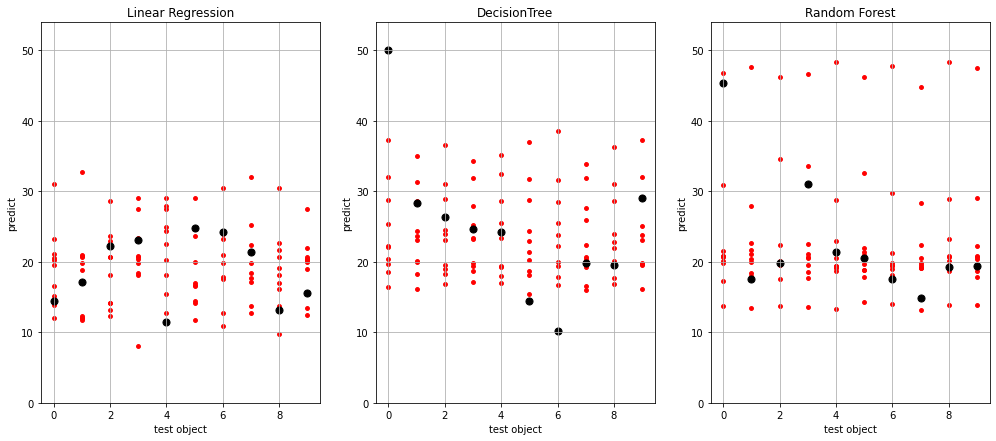

In [214]:
fig, axes = plt.subplots(1, 3, figsize=(17, 7))
plot_predictions(0, reg, X, y, num_runs=100, num_test_objects=10, title="Linear Regression")
plot_predictions(1, clf, X, y, num_runs=100, num_test_objects=10, title="DecisionTree")
plot_predictions(2, regr2, X, y, num_runs=100, num_test_objects=10, title="Random Forest")
#fig

выше нарисованы три графика работы трех моделей


**Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.**

в первом случае линейной регрессии видно, что все ответы расположены близко друг к другу, что говорит о небольшом разбросе, но имеют какое-то смещение. То есть все ответы сконцентрированы, но удалены от истинного.

В случае решающего дерева видно, что ответы расположены далеко друг от друга, что говорит о большом разбросе, но смещение там меньше, чем у линейной регрессии. истинные ответы расположены ближе (в среднем) чем на левом графике.

В случае случайного леса ситуация выглядит лучше. Там меньше разброс, чем в случае решающего дерева, но присутствует небольшое смещение (часто ответы концентрируются вместе, но на отдалении от истинного значения). Видно, что его результаты лучше. 

# Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из соревнования (вам нужны только данные, посылать туда ничего не надо).

- Загрузите таблицу application_train.csv;
- Запишите в Y столбец с целевой переменной (TARGET);
- Удалите ненужные столбцы:
  - Воспользуйтесь описанием соревнования
  - При желании, воспользуйтесь методами feature selection/стат. методами, если хотите. Объясните, что использовали и почему решили выкинуть тот или иной признак.
- Определите тип столбцов и заполните пропуски - стратегия произвольная;
- Разбейте выборку в соотношении 70:30 с random_state=0. Если считаете нужным, сделайте сбалансированное по классам разбиение.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [3]:
data = pd.read_csv("application_train.csv")

In [4]:
data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,0,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,0,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,0,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,239009,0,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
215253,399937,0,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
215254,253016,0,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0
215255,270275,0,Revolving loans,M,Y,Y,1,180000.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
y = data['TARGET']

In [6]:
data = data.drop('TARGET', axis = 1)

In [7]:
data = data.drop('SK_ID_CURR', axis = 1)

In [8]:
list_data = data.columns
#data.columns

In [9]:
s = 0
for i in list_data:
    if(data[i].isnull().sum()/len(data[i]) >= 0.5):
        s += 1
        data = data.drop(i, axis = 1)
s

41

In [10]:
data

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,675000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
215253,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,472500.0,"Spouse, partner",...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
215254,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,1125000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0
215255,Revolving loans,M,Y,Y,1,180000.0,270000.0,13500.0,270000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


выкинули те столбцы, в которых знаачения NaN в столбце встречалось больше чем в половине случаев. Выкинули 41 столбец из 122. Так же убрали столбец таргет и id

In [11]:
data['FLAG_OWN_CAR'].dtype == 'O'

True

In [12]:
list_data_new = data.columns
s = 0
for i in list_data_new:
    if data[i].dtype == 'float64' or data[i].dtype == 'int64':
        data[i].fillna((data[i].mean()), inplace=True)
    if data[i].dtype == 'O':
        s += 1
        data[i].fillna((data[i][0]), inplace=True)
print('columns object', s)

columns object 13


всего 13 столбцов с текстом

In [13]:
s = 0
list_data_new = data.columns
for i in list_data_new:
    if(data[i].isnull().sum() > 0):
        s += 1
s

0

In [14]:
data

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
2,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
3,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,2.000000
4,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,675000.0,Unaccompanied,...,0,0,0,0,0.006416,0.006647,0.03426,0.267319,0.26603,1.899429
215253,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,472500.0,"Spouse, partner",...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,4.000000
215254,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,1125000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,2.000000,0.00000,3.000000
215255,Revolving loans,M,Y,Y,1,180000.0,270000.0,13500.0,270000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, train_size=0.7, random_state=0)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150679, 79), (64578, 79), (150679,), (64578,))

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. Получилась ли заметная разница в качестве? Как вы думаете, почему?

**Замечание:**

- В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [17]:
list_data_float = data.columns
s = 0
data_float = pd.DataFrame()
for i in list_data_float:
    if data[i].dtype == 'float64' or data[i].dtype == 'int64':
        s += 1
        data_float[i] = data[i]
print('float columns', s)

float columns 66


In [18]:
t = 0
for i in list_data_float:
    if data[i].dtype == 'O':
        t += 1
t

13

66 + 13 = 79, все хорошо

In [19]:
data_float

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,157500.0,706410.0,67072.5,679500.0,0.032561,-14653,-2062,-8599.0,-2087,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
1,1,121500.0,545040.0,25407.0,450000.0,0.007114,-13995,-2246,-348.0,-172,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
2,1,225000.0,942300.0,27679.5,675000.0,0.022625,-21687,-1335,-6306.0,-4026,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
3,2,144000.0,180000.0,9000.0,180000.0,0.006629,-13071,-2292,-742.0,-1201,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,2.000000
4,0,112500.0,729792.0,37390.5,630000.0,0.046220,-19666,365243,-169.0,-3112,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,0,121500.0,675000.0,32602.5,675000.0,0.006305,-14481,-1124,-3813.0,-4134,...,0,0,0,0,0.006416,0.006647,0.03426,0.267319,0.26603,1.899429
215253,2,225000.0,509922.0,40419.0,472500.0,0.003069,-15492,-292,-1613.0,-4465,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,4.000000
215254,0,450000.0,1125000.0,33025.5,1125000.0,0.014520,-14309,-5929,-5038.0,-5123,...,0,0,0,0,0.000000,0.000000,0.00000,2.000000,0.00000,3.000000
215255,1,180000.0,270000.0,13500.0,270000.0,0.010006,-12706,-1868,-923.0,-4406,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000


In [443]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [444]:
import lightgbm as lgb

In [449]:
pip install catboost

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=62c33317d568e7105ccde9ba856ec74b7b6e7888239a743c8069052d81b6ad18
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying
  Using cached catboost-0.24.3-cp38-none-win_amd64.whl (65.4 MB)
  Using cached plotly-4.14.1-py2.py3-none-any.whl (13.2 MB)
Note: you may need to restart the kernel to use updated packages.


### CatBoost

In [49]:
from catboost import CatBoostRegressor

In [50]:
from sklearn.model_selection import train_test_split
X_train_float, X_test_float, y_train, y_test = train_test_split(data_float, y, train_size=0.7, random_state=0)

In [51]:

from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier 

In [120]:
X_train_float.shape

(150679, 66)

In [121]:
from catboost import CatBoostClassifier 
import time
clf = CatBoostClassifier( logging_level='Silent')
def time_fit_Cat_Boost():
    start_time = time.time()
    clf.fit(X_train_float, y_train)
    return (time.time() - start_time)
print("Cat_Boost running time %s seconds ---" % time_fit_Cat_Boost())

Cat_Boost running time 49.618475675582886 seconds ---


50 секунд...

In [474]:
print(roc_auc_score(y_test, clf.predict_proba(X_test_float)[:, 1]))

0.7400413783842654


Но нам нужна площадь под precision-recall

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [476]:
y_score_pr = clf.predict_proba(X_test_float)

In [477]:
from sklearn import metrics

precision, recall, third = precision_recall_curve(y_test, y_score_pr[:,1])
metrics.auc(recall, precision)

0.22448830027909078

это площадь под графиком precision-recall кривой

Теперь проделаем то же самое с LightGBM

### LightGBM

In [483]:
from lightgbm import LGBMClassifier

clf2 = LGBMClassifier()

def time_fit_LGBM():
    start_time = time.time()
    clf2.fit(X_train_float, y_train)
    return (time.time() - start_time)
print("LGBM running time %s seconds ---" % time_fit_LGBM())


LGBM running time 1.4204320907592773 seconds ---


меньше двух секунд

In [484]:
print(roc_auc_score(y_test, clf2.predict_proba(X_test_float)[:, 1]))

0.7408920533873434


In [485]:
y_score_pr2 = clf2.predict_proba(X_test_float)

In [33]:
from sklearn import metrics

In [486]:
from sklearn import metrics

precision2, recall2, third2 = precision_recall_curve(y_test, y_score_pr2[:,1])
metrics.auc(recall2, precision2)

0.22647241026885723

Площадь получилась примерно одинаковая. Заметной разницы в качестве не наблюдается.

Вероятно, это связано с тем, что эти алгоритмы схожи по реализации и здесь мы выбирали все параметры ппо умолчанию.

**Задание 6. (2 балла)**

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

- глубину деревьев;
- количество деревьев;
- темп обучения;
- оптимизируемый функционал.


Масштаб значений предлагается посмотреть тут.

**Проанализируйте соотношения получившихся оптимальных глубины и количества деревьев в зависимости от алгоритма.**


**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

### глубина LGBM

In [527]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in list_of_max_depth:
    print('i am working', i)
    start_time = time.time()
    clf_param = LGBMClassifier(max_depth = i, num_leaves= 1024)
    clf_param.fit(X_train_float, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_float)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 1
i am working 2
i am working 3
i am working 4
i am working 5
i am working 6
i am working 7
i am working 8
i am working 9
i am working 10


In [496]:
#list_of_accur

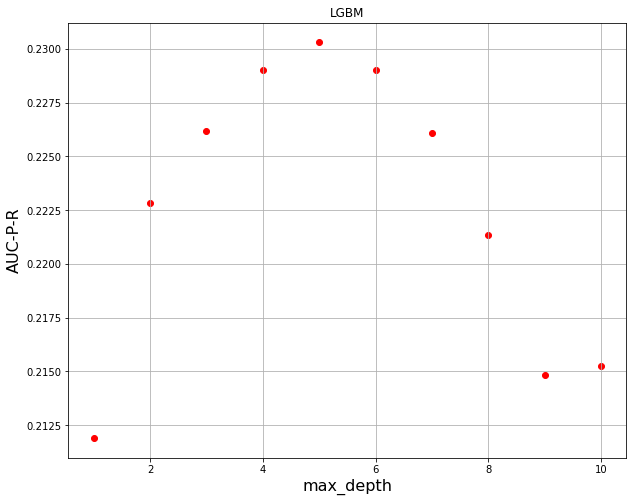

In [528]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_max_depth, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('max_depth', size = 16)
ax.grid()
ax.set_title('LGBM')
plt.show()

**Лучшие показатели LGBM при глубине равной 4**

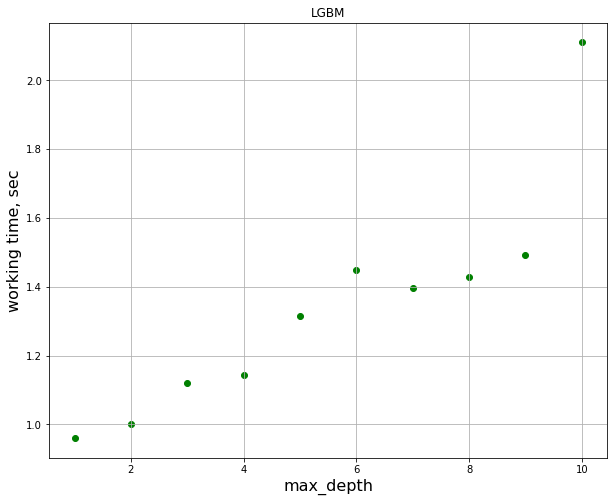

In [526]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_max_depth, list_time, color = 'g')
ax.set_ylabel('working time, sec', size = 16)
ax.set_xlabel('max_depth', size = 16)
ax.grid()
ax.set_title('LGBM')
plt.show()

время работы на лучшем значении не самое большое.

### глубина Cat_boost

In [519]:
from catboost import CatBoostClassifier 
list_time = []
list_of_accur = []
list_of_max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in list_of_max_depth:
    print('i am working', i)
    start_time = time.time()
    clf_param = CatBoostClassifier(max_depth = i, logging_level='Silent')
    clf_param.fit(X_train_float, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_float)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 1
i am working 2
i am working 3
i am working 4
i am working 5
i am working 6
i am working 7
i am working 8
i am working 9
i am working 10


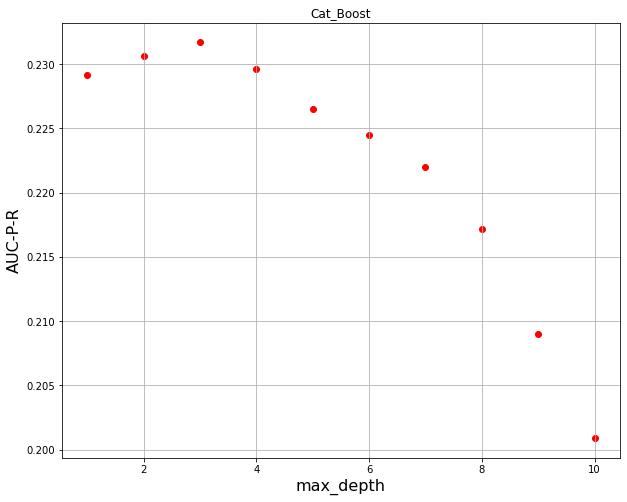

In [520]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_max_depth, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('max_depth', size = 16)
ax.grid()
ax.set_title('Cat_Boost')
plt.show()

**Лучшие результаты Cat_Boost достигает при глубине 3**

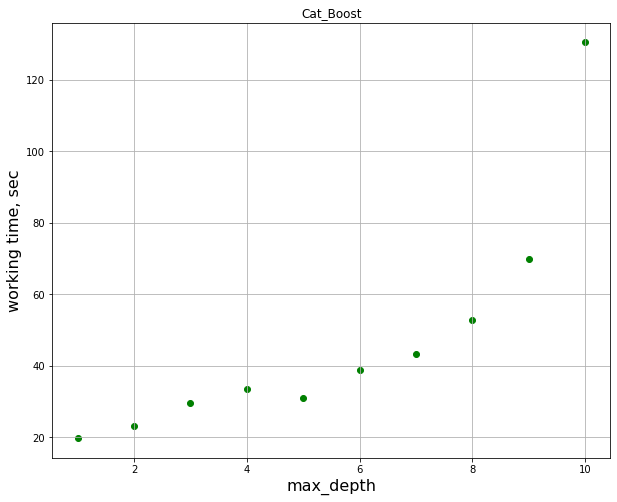

In [521]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_max_depth, list_time, color = 'g')
ax.set_ylabel('working time, sec', size = 16)
ax.set_xlabel('max_depth', size = 16)
ax.grid()
ax.set_title('Cat_Boost')
plt.show()

время работы при наилучшем результате небольшое. Стоит отметить, что при уведичении глубины время работы возрастает, а качество падает.

In [522]:
from catboost import CatBoostClassifier 
list_time = []
list_of_accur = []
list_of_max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in list_of_max_depth:
    print('i am working', i)
    start_time = time.time()
    clf_param = CatBoostClassifier(max_depth = i, n_estimators = 500, logging_level='Silent')
    clf_param.fit(X_train_float, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_float)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 1
i am working 2
i am working 3
i am working 4
i am working 5
i am working 6
i am working 7
i am working 8
i am working 9
i am working 10


In [523]:
list_time

[8.826900482177734,
 11.94880986213684,
 13.545079469680786,
 14.068893432617188,
 20.07734489440918,
 25.561068058013916,
 30.31310725212097,
 36.75887489318848,
 40.62406349182129,
 72.05118012428284]

### количество деревьев для LGBM

In [533]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_trees = [1, 5, 10, 20, 50, 100, 200, 400, 600, 1000, 1300, 1700, 2200, 2500, 3000]
for i in list_of_trees:
    print('i am working', i)
    start_time = time.time()
    clf_param = LGBMClassifier(n_estimators  = i)
    clf_param.fit(X_train_float, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_float)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 1
i am working 5
i am working 10
i am working 20
i am working 50
i am working 100
i am working 200
i am working 400
i am working 600
i am working 1000
i am working 1300
i am working 1700
i am working 2200
i am working 2500
i am working 3000


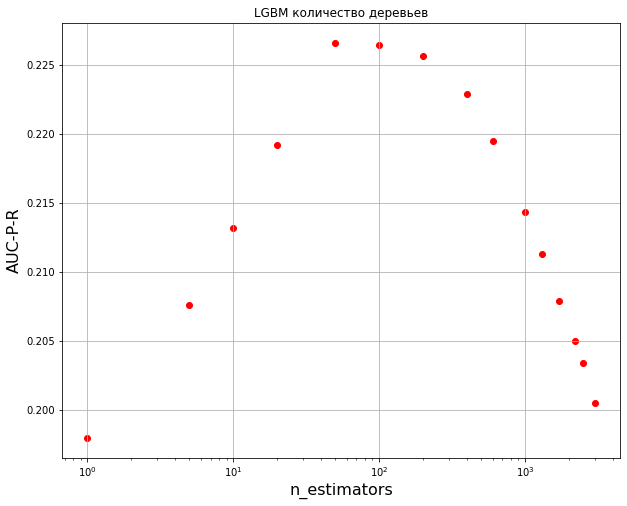

In [539]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_trees, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('n_estimators', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('LGBM количество деревьев')
plt.show()

**лучшая точность LGBM на значениях количества деревьев 50, 100, 200**

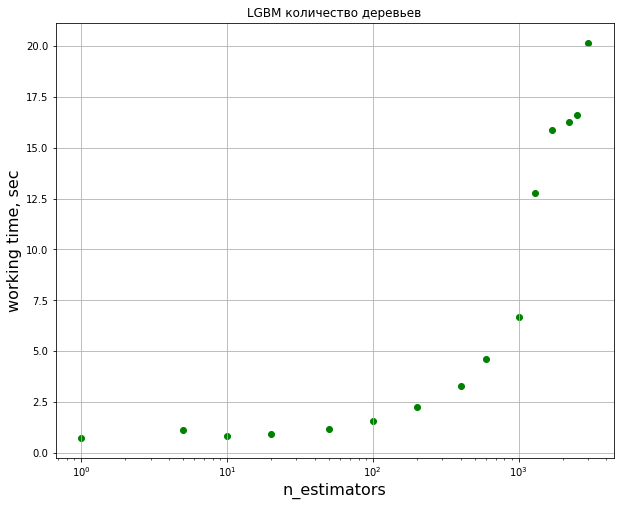

In [540]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_trees, list_time, color = 'g')
ax.set_ylabel('working time, sec', size = 16)
ax.set_xlabel('n_estimators', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('LGBM количество деревьев')
plt.show()

видна та же тенденция, что при увеличении количества деревьев точность падает, а время работы увеличивается.

### количество деревьев для Cat_Boost

In [542]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_trees = [1, 5, 10, 20, 50, 100, 200, 400, 600, 1000, 1300, 1700, 2200, 2500, 3000]
for i in list_of_trees:
    print('i am working', i)
    start_time = time.time()
    clf_param = CatBoostClassifier(n_estimators  = i, logging_level='Silent')
    clf_param.fit(X_train_float, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_float)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 1
i am working 5
i am working 10
i am working 20
i am working 50
i am working 100
i am working 200
i am working 400
i am working 600
i am working 1000
i am working 1300
i am working 1700
i am working 2200
i am working 2500
i am working 3000


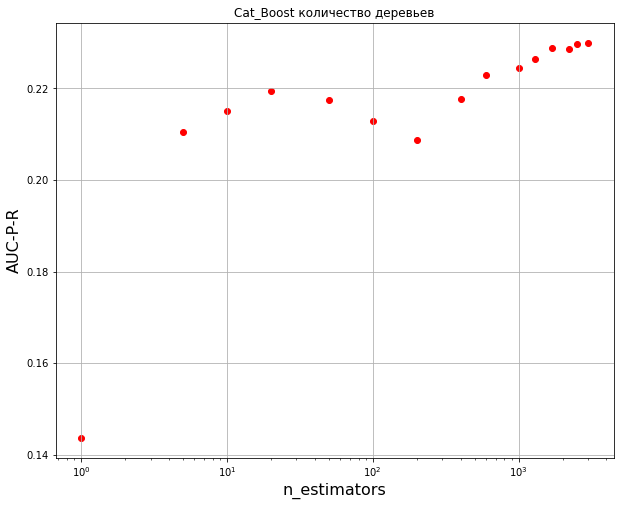

In [543]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_trees, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('n_estimators', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('Cat_Boost количество деревьев')
plt.show()

**здесь же лучшие показатели при значениях бОльших 1000, причем качество перестает расти, а время работы (ниже), резко возрастает**

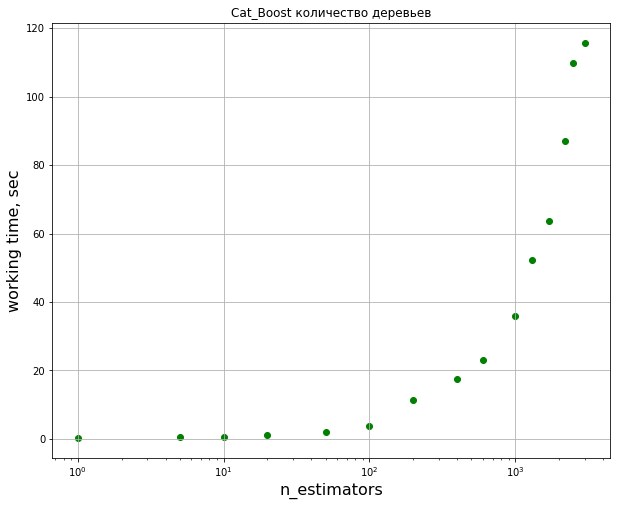

In [544]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_trees, list_time, color = 'g')
ax.set_ylabel('working time, sec', size = 16)
ax.set_xlabel('n_estimators', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('Cat_Boost количество деревьев')
plt.show()

## темп обучения для LGBM

In [554]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_learning_rate  = [0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.99]
for i in list_of_learning_rate:
    print('i am working', i)
    start_time = time.time()
    clf_param = LGBMClassifier(learning_rate = i)
    clf_param.fit(X_train_float, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_float)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 0.01
i am working 0.02
i am working 0.03
i am working 0.05
i am working 0.08
i am working 0.1
i am working 0.15
i am working 0.2
i am working 0.3
i am working 0.5
i am working 0.7
i am working 0.99


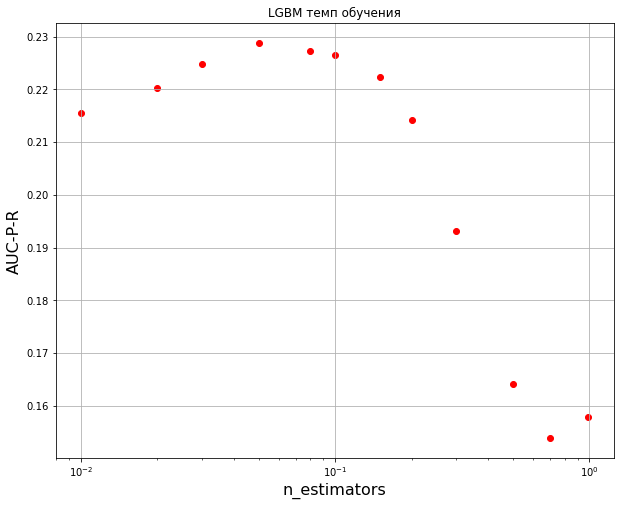

In [555]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_learning_rate, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('n_estimators', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('LGBM темп обучения')
plt.show()

по оси х должно быть темп обучения, описка

**лучшие показатели LGBM показывает при значении learning_rate = 0.05**

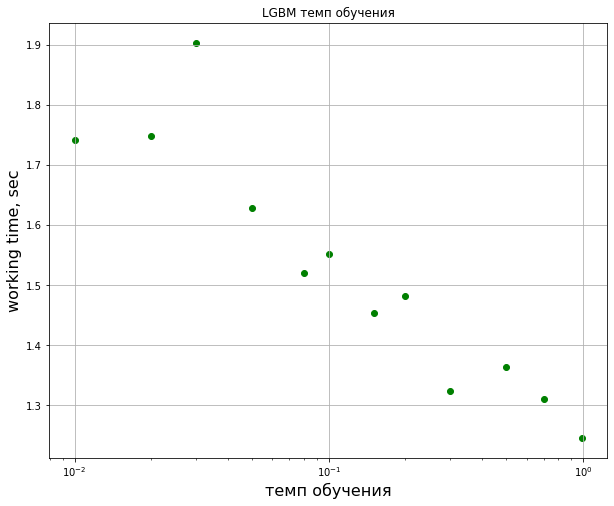

In [556]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_learning_rate, list_time, color = 'g')
ax.set_ylabel('working time, sec', size = 16)
ax.set_xlabel('темп обучения', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('LGBM темп обучения')
plt.show()

время ведет себя немного странно, но видна тенденция на уменьшение

### Темп обучения Cat_Boost

In [557]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_learning_rate  = [0.01, 0.02, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.99]
for i in list_of_learning_rate:
    print('i am working', i)
    start_time = time.time()
    clf_param = CatBoostClassifier(learning_rate = i, logging_level='Silent')
    clf_param.fit(X_train_float, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_float)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 0.01
i am working 0.02
i am working 0.05
i am working 0.08
i am working 0.1
i am working 0.15
i am working 0.2
i am working 0.3
i am working 0.5
i am working 0.7
i am working 0.99


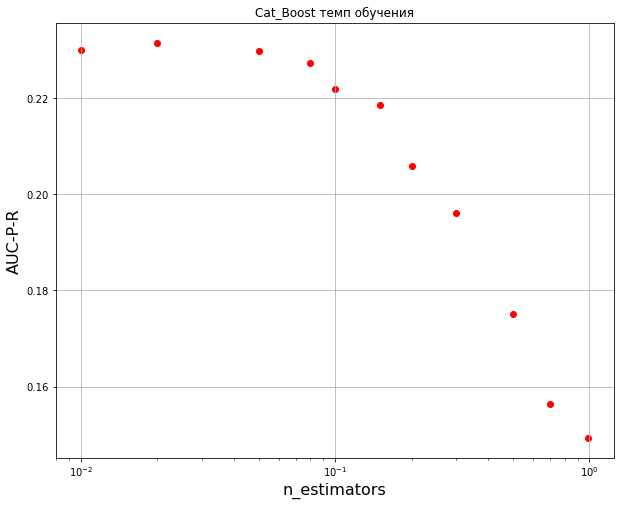

In [558]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_learning_rate, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('n_estimators', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('Cat_Boost темп обучения')
plt.show()

по оси х должно быть темп обучения, тут тоже просто скопировал неудачно ( не стал исправлять из-за большого времени работы)

**У Cat_Boost лучшие показатели точности получаются при learning_rate = 0.02, зависимости от времени работы особо не наблюдается**

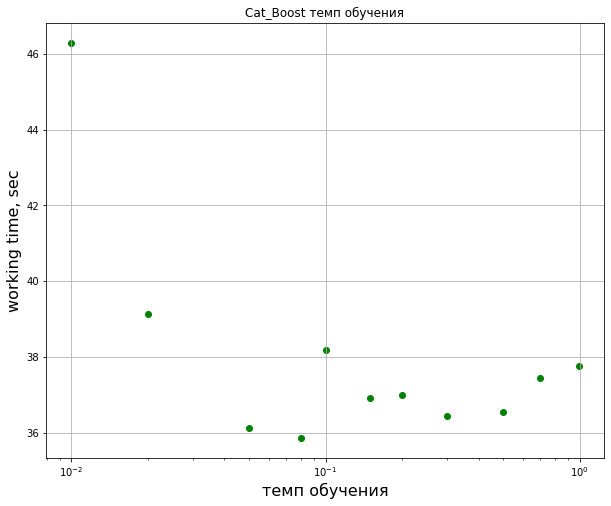

In [559]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_learning_rate, list_time, color = 'g')
ax.set_ylabel('working time, sec', size = 16)
ax.set_xlabel('темп обучения', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('Cat_Boost темп обучения')
plt.show()

### Оптимизируемый функционал для LGBM

In [77]:
import time
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_objective = ['binary', 'cross_entropy']
for i in list_of_objective:
    print('i am working', i)
    start_time = time.time()
    clf_param = LGBMClassifier(objective = i)
    clf_param.fit(X_train_float, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_float)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working binary
i am working cross_entropy


In [82]:
list_of_accur

[0.22647241026885723, 0.22647241026885723]

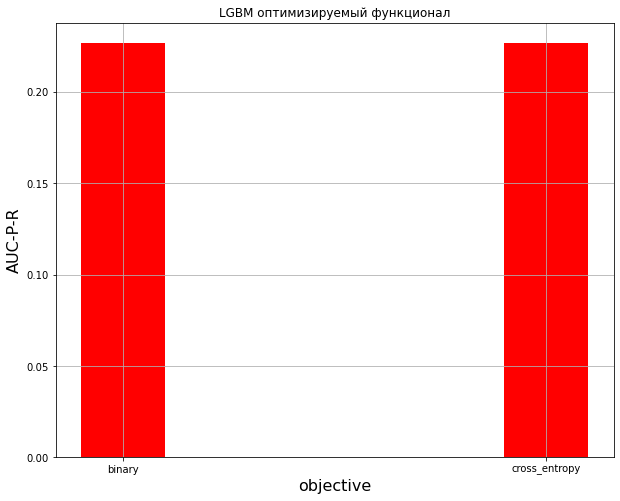

In [80]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.bar(list_of_objective, list_of_accur, color = 'r', width = 0.2)
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('objective', size = 16)
ax.grid()
#plt.xscale("log")
ax.set_title('LGBM оптимизируемый функционал')
plt.show()

**У LGBM получились 2 равных значения точности, но время работы cross-entropy немного ниже**

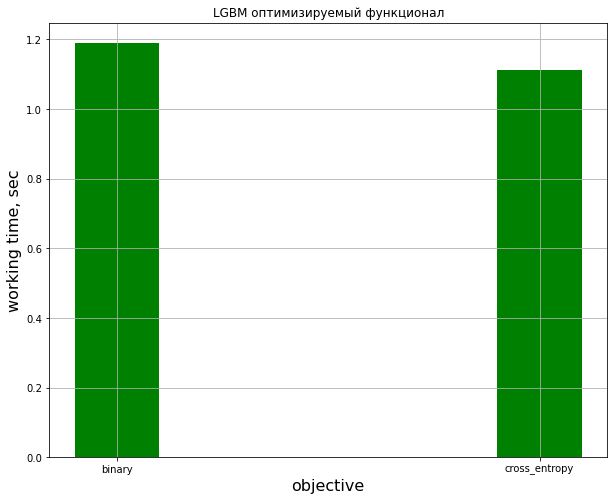

In [81]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.bar(list_of_objective, list_time, color = 'g', width = 0.2)
ax.set_ylabel('working time, sec', size = 16)
ax.set_xlabel('objective', size = 16)
ax.grid()
ax.set_title('LGBM оптимизируемый функционал')
plt.show()

### Оптимизируемый функционал для Cat_Boost

In [70]:
import time
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
#list_of_objective = ['regression', 'regression_l1', 'huber', 'fair', 'poisson', 'quantile', 'mape']
list_of_objective = [ 'Logloss', 'CrossEntropy', 'MultiClass', 'MultiClassOneVsAll']
for i in list_of_objective:
    print('i am working', i)
    start_time = time.time()
    clf_param = CatBoostClassifier(objective = i, logging_level='Silent')
    clf_param.fit(X_train_float, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_float)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working Logloss
i am working CrossEntropy
i am working MultiClass
i am working MultiClassOneVsAll


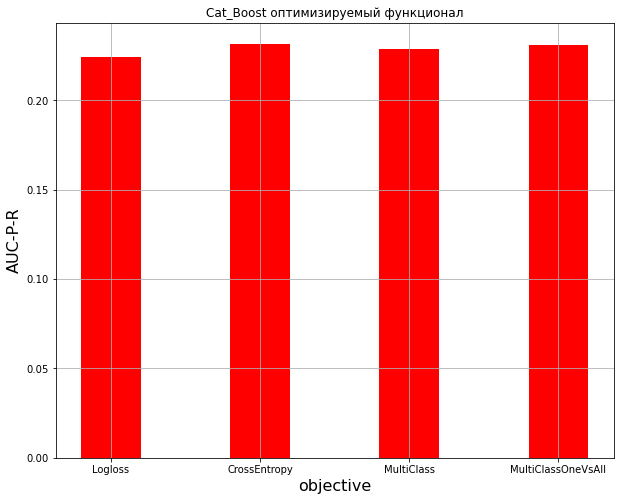

In [71]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.bar(list_of_objective, list_of_accur, color = 'r', width = 0.4)
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('objective', size = 16)
ax.grid()
#plt.xscale("log")
ax.set_title('Cat_Boost оптимизируемый функционал')
plt.show()

**Cat_Boost показал лучшую точность на Cross-Entropy и так же почти самое маленькое время работы, хотя у MultiClassOneVsAll при примерно той же точности время работы значительно выше**

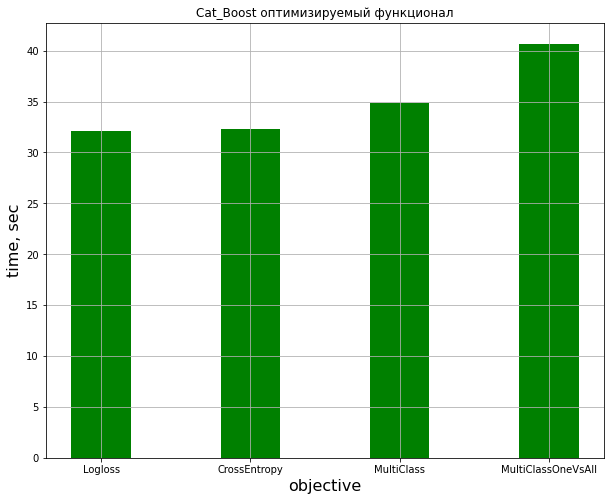

In [72]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.bar(list_of_objective, list_time, color = 'g', width = 0.4)
ax.set_ylabel('time, sec', size = 16)
ax.set_xlabel('objective', size = 16)
ax.grid()
#plt.xscale("log")
ax.set_title('Cat_Boost оптимизируемый функционал')
plt.show()

**Your answer here:**

**Задание 7 (1.5 баллa)**

Добавьте категориальные признаки к вещественным следующими способами:

- как OHE признаки;
- как счетчики со сглаживанием.

Можно использовать библиотечные реализации; при подсчете счетчиков нельзя использовать циклы.

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? (Параметры можно не подбирать).

In [110]:
#data

In [111]:
data_float.shape

(215257, 66)

### OHE

In [86]:
from sklearn.preprocessing import OneHotEncoder

In [88]:
list_data_cat = data.columns
s = 0
data_cat = pd.DataFrame()
for i in list_data_cat:
    if data[i].dtype == 'O':
        s += 1
        data_cat[i] = data[i]
print('cat columns', s)

cat columns 13


In [112]:
data_cat.shape

(215257, 13)

In [99]:
list_unique = data_cat.columns
un = 0
for i in list_unique:
    un += len(data_cat[i].unique())
un

126

In [91]:
enc = OneHotEncoder(handle_unknown='ignore')

In [92]:
enc.fit(data_cat)

OneHotEncoder(handle_unknown='ignore')

In [94]:
enc.transform(data_cat)

<215257x126 sparse matrix of type '<class 'numpy.float64'>'
	with 2798341 stored elements in Compressed Sparse Row format>

In [106]:
sprace_cat = enc.fit_transform(data_cat)
sprace_cat

<215257x126 sparse matrix of type '<class 'numpy.float64'>'
	with 2798341 stored elements in Compressed Sparse Row format>

In [105]:
import scipy
sprace_data_float = scipy.sparse.csr_matrix(data_float.values)
sprace_data_float

<215257x66 sparse matrix of type '<class 'numpy.float64'>'
	with 6660960 stored elements in Compressed Sparse Row format>

In [107]:
data_float.shape

(215257, 66)

In [108]:
import scipy.sparse as sp

sprace_OHE = sp.hstack((sprace_data_float, sprace_cat), format='csr')
sprace_OHE

<215257x192 sparse matrix of type '<class 'numpy.float64'>'
	with 9459301 stored elements in Compressed Sparse Row format>

In [114]:
from sklearn.model_selection import train_test_split
X_train_OHE, X_test_OHE, y_train, y_test = train_test_split(sprace_OHE, y, train_size=0.7, random_state=0)

In [133]:
X_train_OHE.shape, X_test_OHE.shape

((150679, 192), (64578, 192))

создали OHE матрицу

### время для OHE

In [118]:
from lightgbm import LGBMClassifier
clf = CatBoostClassifier(logging_level='Silent')
def time_fit_OHE_Cat_Boost():
    start_time = time.time()
    clf.fit(X_train_OHE, y_train)
    return (time.time() - start_time)
print("Cat_Boost OHE running time %s seconds ---" % time_fit_OHE_Cat_Boost())

Cat_Boost OHE running time 50.2687726020813 seconds ---


In [138]:
from lightgbm import LGBMClassifier
clf = LGBMClassifier()
def time_fit_OHE_LGBM():
    start_time = time.time()
    clf.fit(X_train_OHE, y_train)
    return (time.time() - start_time)
print("LGBM OHE running time %s seconds ---" % time_fit_OHE_LGBM())

LGBM OHE running time 1.6812593936920166 seconds ---


### Счетчики

In [122]:
pip install category_encoders


Note: you may need to restart the kernel to use updated packages.


In [123]:
from category_encoders.count import CountEncoder

In [126]:
data_cat.shape

(215257, 13)

In [128]:
encc = CountEncoder()
cat_count_enc = encc.fit_transform(data_cat)
cat_count_enc

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE
0,194663,141565,141832,65738,174704,50219,52664,137750,191042,69271,36443,1077,213630
1,194663,141565,73425,149519,174704,111082,152634,137750,191042,929,35452,47560,213630
2,194663,73689,73425,149519,174704,111082,152634,137750,7744,38710,35534,26852,213630
3,20594,141565,141832,149519,174704,50219,152634,13745,191042,4090,35452,1255,213630
4,194663,141565,141832,149519,174704,38709,152634,20780,191042,69271,35111,38716,213630
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,194663,141565,141832,149519,174704,111082,152634,31782,191042,4090,35452,26852,213630
215253,194663,141565,141832,65738,7954,50219,152634,137750,191042,22344,37706,5459,213630
215254,194663,73689,73425,149519,174704,111082,52664,31782,191042,14976,35452,26852,213630
215255,20594,73689,73425,149519,174704,111082,152634,137750,191042,13030,35452,7449,213630


In [129]:
import scipy
sprace_cat_count_enc = scipy.sparse.csr_matrix(cat_count_enc.values)
sprace_cat_count_enc

<215257x13 sparse matrix of type '<class 'numpy.int64'>'
	with 2798341 stored elements in Compressed Sparse Row format>

In [130]:
import scipy.sparse as sp

sprace_count = sp.hstack((sprace_data_float, sprace_cat_count_enc), format='csr')
sprace_count

<215257x79 sparse matrix of type '<class 'numpy.float64'>'
	with 9459301 stored elements in Compressed Sparse Row format>

In [131]:
from sklearn.model_selection import train_test_split
X_train_count, X_test_count, y_train, y_test = train_test_split(sprace_count, y, train_size=0.7, random_state=0)

In [132]:
X_train_count.shape, X_test_count.shape

((150679, 79), (64578, 79))

### Время для счетчиков

In [134]:
from lightgbm import LGBMClassifier
clf = CatBoostClassifier(logging_level='Silent')
def time_fit_Counters_Cat_Boost():
    start_time = time.time()
    clf.fit(X_train_count, y_train)
    return (time.time() - start_time)
print("Cat_Boost Counters running time %s seconds ---" % time_fit_Counters_Cat_Boost())

Cat_Boost Counters running time 47.24519324302673 seconds ---


In [137]:
from lightgbm import LGBMClassifier
clf = LGBMClassifier()
def time_fit_Counters_LGBM():
    start_time = time.time()
    clf.fit(X_train_OHE, y_train)
    return (time.time() - start_time)
print("LGBM Counters running time %s seconds ---" % time_fit_Counters_LGBM())

LGBM Counters running time 1.6666264533996582 seconds ---


**Из экспериментов видно, что время обучения и для OHE и для счетчиков со сглаживанием в обоих случаях (LGBM и Cat Boost) время работы различается несущественно, хотя количество признаков различается в 2.5 раза (Для OHE это 192, для счетчиков 79)**

**Задание 8 (1 балл)**

Для CatBoost можно не делать ручную обработку категориальных признаков, а подавать как есть. Обучите модель CatBoost, не обрабатывая специально категориальные признаки, замерьте время обучения (параметры возьмите из предыдущего пункта). Сравните с временем обучения модели CatBoost из предыдущего пункта. Как изменилось время? Почему?

In [139]:
data

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
2,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
3,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,2.000000
4,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,675000.0,Unaccompanied,...,0,0,0,0,0.006416,0.006647,0.03426,0.267319,0.26603,1.899429
215253,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,472500.0,"Spouse, partner",...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,4.000000
215254,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,1125000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,2.000000,0.00000,3.000000
215255,Revolving loans,M,Y,Y,1,180000.0,270000.0,13500.0,270000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000


In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, train_size=0.7, random_state=0)

In [145]:
X_train.shape, X_test.shape

((150679, 79), (64578, 79))

In [150]:
list_data_last = data.columns
s = 0
ll = []
for i in list_data_last:
    if data[i].dtype == 'O':
        ll += [s]
    s += 1
print('cat columns', ll)

cat columns [0, 1, 2, 3, 9, 10, 11, 12, 13, 25, 29, 37, 47]


In [151]:
from lightgbm import LGBMClassifier
clf = CatBoostClassifier(logging_level='Silent')
def time_fit_no_trans_Cat_Boost():
    start_time = time.time()
    clf.fit(X_train, y_train, cat_features = ll)
    return (time.time() - start_time)
print("Cat_Boost no transform running time %s seconds ---" % time_fit_no_trans_Cat_Boost())

Cat_Boost no transform running time 171.65143585205078 seconds ---


**время работы в этом случае в три раза больше**

Можно сделать вывод о том, что на время работы в большей степени влияет количество катериголиальных признаков. (чем их больше, тем время обучения больше), а не количество вещественных признаков.

**Бонус. (1 балл)**

Подберите оптимальные параметры для LightGBM с вещественными и категориальными признаками (предварительно обработанные каким-нибудь способом). Подберите оптимальные параметры для CatBoost с вещественными и необработанными категориальными признаками. Сравните качество моделей на наилучших параметрах. Какой метод получился лучше с точки зрения качества? Совпадает ли результат с вашими ожиданиями?

### LightGBM

In [157]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in list_of_max_depth:
    print('i am working', i)
    start_time = time.time()
    clf_param = LGBMClassifier(max_depth = i, num_leaves= 1024)
    clf_param.fit(X_train_count, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_count)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]


i am working 1
i am working 2
i am working 3
i am working 4
i am working 5
i am working 6
i am working 7
i am working 8
i am working 9
i am working 10


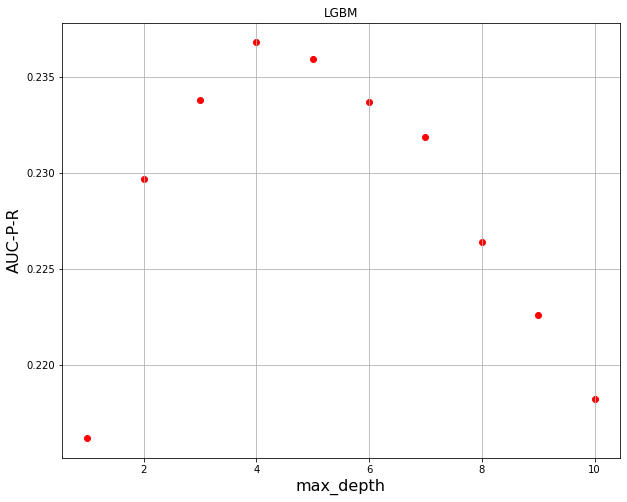

In [158]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_max_depth, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('max_depth', size = 16)
ax.grid()
ax.set_title('LGBM')
plt.show()

In [159]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_trees = [1, 5, 10, 20, 50, 100, 200, 400, 600, 1000, 1300, 1700, 2200, 2500, 3000]
for i in list_of_trees:
    print('i am working', i)
    start_time = time.time()
    clf_param = LGBMClassifier(n_estimators  = i)
    clf_param.fit(X_train_count, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_count)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 1
i am working 5
i am working 10
i am working 20
i am working 50
i am working 100
i am working 200
i am working 400
i am working 600
i am working 1000
i am working 1300
i am working 1700
i am working 2200
i am working 2500
i am working 3000


In [162]:
list_of_trees

[1, 5, 10, 20, 50, 100, 200, 400, 600, 1000, 1300, 1700, 2200, 2500, 3000]

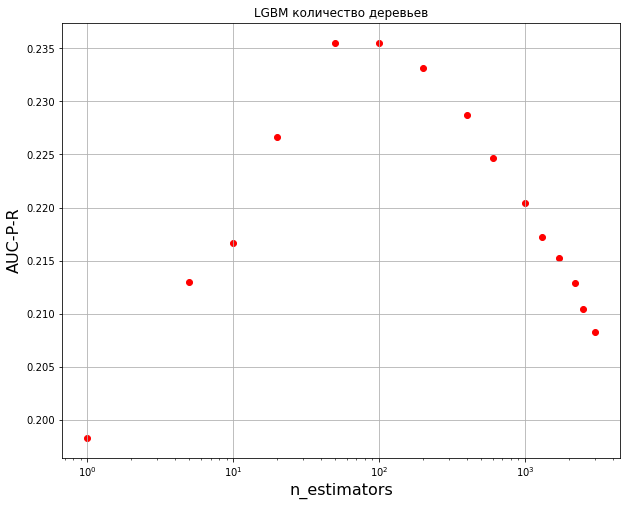

In [160]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_trees, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('n_estimators', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('LGBM количество деревьев')
plt.show()

In [167]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_learning_rate  = [0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 0.99]
for i in list_of_learning_rate:
    print('i am working', i)
    start_time = time.time()
    clf_param = LGBMClassifier(learning_rate = i)
    clf_param.fit(X_train_count, y_train)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test_count)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 0.01
i am working 0.02
i am working 0.03
i am working 0.05
i am working 0.08
i am working 0.1
i am working 0.15
i am working 0.2
i am working 0.3
i am working 0.5
i am working 0.7
i am working 0.99


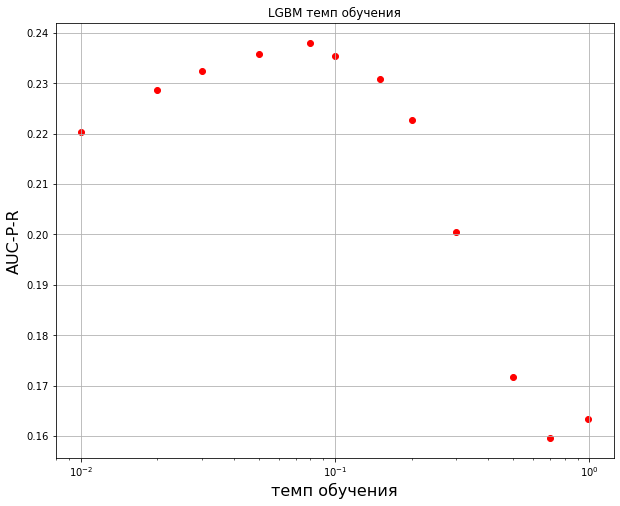

In [168]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_learning_rate, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('темп обучения', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('LGBM темп обучения')
plt.show()

### Теперь найдем параметры для Cat_Boost

In [165]:
from catboost import CatBoostClassifier 
list_time = []
list_of_accur = []
list_of_max_depth = [1, 2, 3, 4, 5, 6]
for i in list_of_max_depth:
    print('i am working', i)
    start_time = time.time()
    clf_param = CatBoostClassifier(max_depth = i, logging_level='Silent')
    clf_param.fit(X_train, y_train, cat_features = ll )
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 1
i am working 2
i am working 3
i am working 4
i am working 5
i am working 6


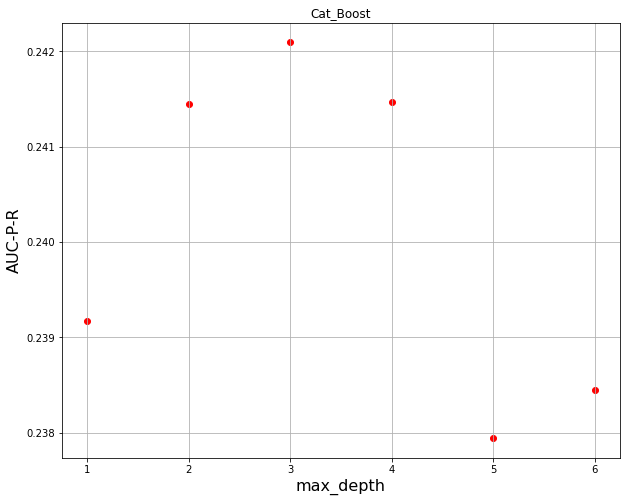

In [166]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_max_depth, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('max_depth', size = 16)
ax.grid()
ax.set_title('Cat_Boost')
plt.show()

In [169]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_trees = [5, 10, 20, 50, 100, 200, 400, 600, 1000]
for i in list_of_trees:
    print('i am working', i)
    start_time = time.time()
    clf_param = CatBoostClassifier(n_estimators  = i, logging_level='Silent')
    clf_param.fit(X_train, y_train, cat_features = ll)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 5
i am working 10
i am working 20
i am working 50
i am working 100
i am working 200
i am working 400
i am working 600
i am working 1000


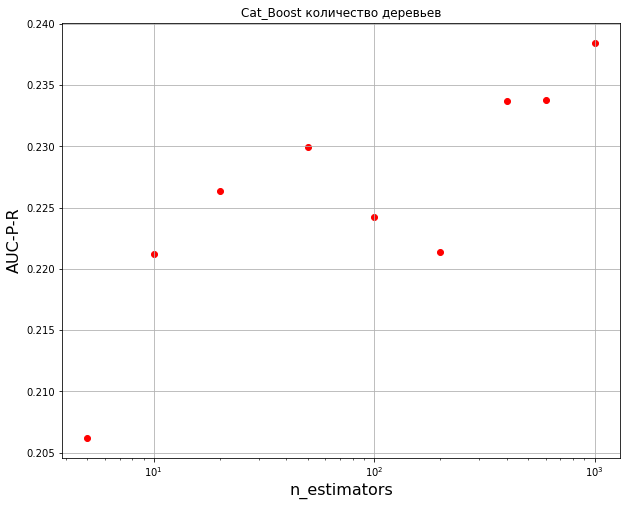

In [170]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_trees, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('n_estimators', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('Cat_Boost количество деревьев')
plt.show()

In [172]:
from lightgbm import LGBMClassifier
list_time = []
list_of_accur = []
list_of_learning_rate  = [0.02, 0.05, 0.08, 0.1, 0.15, 0.2]
for i in list_of_learning_rate:
    print('i am working', i)
    start_time = time.time()
    clf_param = CatBoostClassifier(learning_rate = i, logging_level='Silent')
    clf_param.fit(X_train, y_train,  cat_features = ll)
    t = time.time() - start_time
    list_time += [t]
    y_score_pr_param = clf_param.predict_proba(X_test)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    list_of_accur += [metrics.auc(recall, precision)]

i am working 0.02
i am working 0.05
i am working 0.08
i am working 0.1
i am working 0.15
i am working 0.2


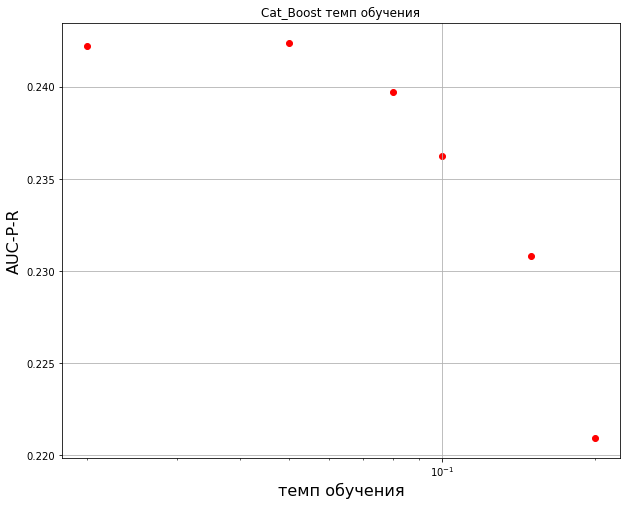

In [174]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(list_of_learning_rate, list_of_accur, color = 'r')
ax.set_ylabel('AUC-P-R', size = 16)
ax.set_xlabel('темп обучения', size = 16)
ax.grid()
plt.xscale("log")
ax.set_title('Cat_Boost темп обучения')
plt.show()

посмотим на качество при лучших параметрах в обоих случаях

In [176]:
from lightgbm import LGBMClassifier
def time_fit_Cat_Boost_fin():
    start_time = time.time()
    clf_param = CatBoostClassifier(max_depth = 3, learning_rate = 0.05, n_estimators  = 1000, logging_level='Silent')
    clf_param.fit(X_train, y_train,  cat_features = ll)
    y_score_pr_param = clf_param.predict_proba(X_test)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    print(metrics.auc(recall, precision))
    return (time.time() - start_time)
print("Cat_Boost finally running time %s seconds ---" % time_fit_Cat_Boost_fin())

0.24275214215038782
Cat_Boost finally running time 121.99077558517456 seconds ---


**точость при наилучших значениях каждого параметра - 0.2427**

In [189]:
from lightgbm import LGBMClassifier
def time_fit_LGBM_fin():
    start_time = time.time()
    clf_param = LGBMClassifier(max_depth = 4, n_estimators  = 500, learning_rate = 0.08)
    #clf_param = LGBMClassifier(n_estimators  = 100)
    clf_param.fit(X_train_count, y_train)
    y_score_pr_param = clf_param.predict_proba(X_test_count)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    print(metrics.auc(recall, precision))
    return (time.time() - start_time)
print("LGBM finally running time %s seconds ---" % time_fit_LGBM_fin())

0.23922291244406646
LGBM finally running time 3.852090835571289 seconds ---


 n_estimators  = 500 с остальными параметрами

In [190]:
from lightgbm import LGBMClassifier
def time_fit_LGBM_fin():
    start_time = time.time()
    #clf_param = LGBMClassifier(max_depth = 4, n_estimators  = 500, learning_rate = 0.08)
    clf_param = LGBMClassifier(n_estimators  = 100)
    clf_param.fit(X_train_count, y_train)
    y_score_pr_param = clf_param.predict_proba(X_test_count)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    print(metrics.auc(recall, precision))
    return (time.time() - start_time)
print("LGBM finally running time %s seconds ---" % time_fit_LGBM_fin())

0.2354869686893707
LGBM finally running time 2.19692063331604 seconds ---


n_estimators = 100 отдельно

In [192]:
from lightgbm import LGBMClassifier
def time_fit_LGBM_fin():
    start_time = time.time()
    #clf_param = LGBMClassifier(max_depth = 4, n_estimators  = 500, learning_rate = 0.08)
    clf_param = LGBMClassifier(n_estimators  = 500)
    clf_param.fit(X_train_count, y_train)
    y_score_pr_param = clf_param.predict_proba(X_test_count)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    print(metrics.auc(recall, precision))
    return (time.time() - start_time)
print("LGBM finally running time %s seconds ---" % time_fit_LGBM_fin())

0.22570863481562956
LGBM finally running time 4.865719795227051 seconds ---


n_estimators = 500 отдельно

In [193]:
from lightgbm import LGBMClassifier
def time_fit_LGBM_fin():
    start_time = time.time()
    clf_param = LGBMClassifier(max_depth = 4, n_estimators  = 100, learning_rate = 0.08)
    #clf_param = LGBMClassifier(n_estimators  = 100)
    clf_param.fit(X_train_count, y_train)
    y_score_pr_param = clf_param.predict_proba(X_test_count)
    precision, recall, third = precision_recall_curve(y_test, y_score_pr_param[:,1])
    print(metrics.auc(recall, precision))
    return (time.time() - start_time)
print("LGBM finally running time %s seconds ---" % time_fit_LGBM_fin())

0.23559923413960696
LGBM finally running time 1.4330494403839111 seconds ---


n_estimators = 100 с остальными параметрами

**в ходе последнего эксперимента выяснилось, что параметры не являются независимыми, и если брать лучшие значения всех показателей, то точность не является самой лучшей. Как показано выше, при n_estimators = 100 точность выше чем при 500, но подставив остальные параметры точность при 500 уже лучше.**


**на Cat_boost очень долго считаются значения, поэтому там подбирать лучшие значения мы не станем. Но даже не подбирая специально пареметры, чтобы точность их композиции была выше видно, что Cat_Boost показал лучшие значения. Однако время его работы в разы больше!**

То что точность на Cat_Boost выше совпадает с ожиданиями, потому что если при таком времени работы еще и не получить выигрыш в точности, то непонятно зачем вообще такой алгоритм создали. А создали его неглупые люди из яндекса относительно недавно, так что все сходится с ожиданиями


**Бонус (0.2 балла)**

Вставьте лучший мем 2020

![alt text](memes.jpg "Title")

## И адаптированная версия для взрослых





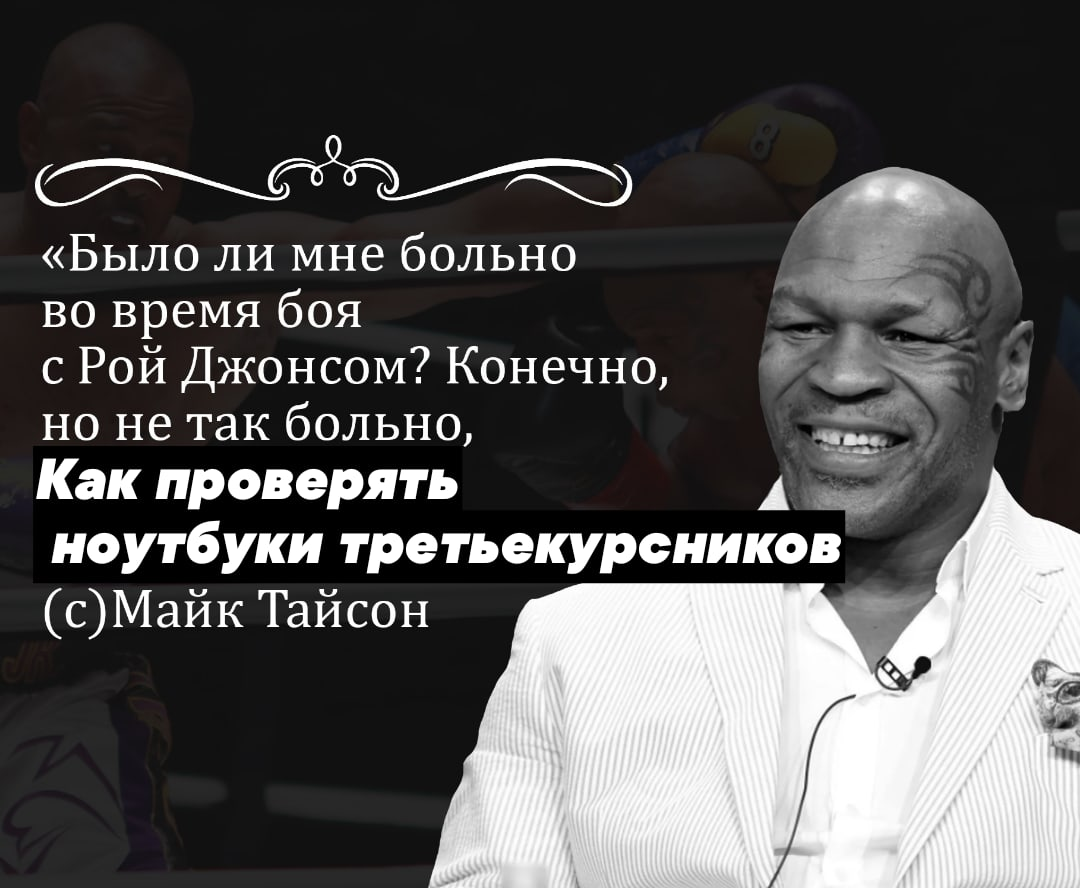

In [2]:
from IPython.display import Image
Image("memes_for_old.jpg")